In [1]:
# ~~~~ STEP 1: IMPORTS ~~~~
# CORE LIBRARIES
import numpy as np
import pandas as pd

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SCIKIT-LEARN UTILITIES
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# OUR THREE CLASSIFIERS (KNN, Logistic Regression, Random Forest)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# EVALUATION METRICS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# just for personal testing
import os
import time

In [2]:
# ~~~~~~~~ STEP 2: PREPROCESSING DATASETS ~~~~~~~~

# ~~~~ 2A: HUMAN ACTIVITY RECOGNITION DATASET ~~~~
# https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones
# LABEL CONVERSION:
    # POSITIVE = walking, walking_upstairs, walking_downstairs
    # NEGATIVE = sitting, standing, laying

# The HAR dataset is split across the following files:
# - 'features_info.txt': Shows information about the variables used on the feature vector.
# - 'features.txt': List of all features.
# - 'activity_labels.txt': Links the class labels with their activity name.
# - 'train/X_train.txt': Training set.
# - 'train/y_train.txt': Training labels.
# - 'test/X_test.txt': Test set.
# - 'test/y_test.txt': Test labels.
# Evidently, we will need to merge these for our HAR dataframe.

HAR_BASE_PATH = 'data/UCI HAR Dataset/'

# helper function
def load_har_data(path, names=None):
    df = pd.read_csv(HAR_BASE_PATH + path,
                    sep=r'\s+',
                    header=None,
                    names=names)
    return df

# Make feature names unique (we have duplicate names in the original HAR files)
def make_unique(names):
    counts = {}
    unique_names = []
    for name in names:
        if name not in counts:
            counts[name] = 0
            unique_names.append(name)
        else:
            counts[name] += 1
            unique_names.append(f"{name}_{counts[name]}")
    return unique_names

# load feature names and activity labels
har_features = load_har_data('features.txt', names=['index', 'feature_name'])
har_feature_names = make_unique(har_features['feature_name'].values)
activity_labels = load_har_data('activity_labels.txt', names=['id', 'activity'])

# load X_train, X_test, y_train, y_test
har_X_train = load_har_data('train/X_train.txt', har_feature_names)
har_X_test = load_har_data('test/X_test.txt', har_feature_names)
har_y_train = load_har_data('train/y_train.txt', ['ActivityID'])
har_y_test = load_har_data('test/y_test.txt', ['ActivityID'])

# mappings
har_activity_map = dict(zip(activity_labels['id'], activity_labels['activity']))
har_y_train['Activity'] = har_y_train['ActivityID'].map(har_activity_map)
har_y_test['Activity'] = har_y_test['ActivityID'].map(har_activity_map)

# combining features and labels
har_X = pd.concat([har_X_train, har_X_test]).reset_index(drop=True)
har_y = pd.concat([har_y_train, har_y_test]).reset_index(drop=True)

# assign labels, where motion activities are +1, stationary activities -1.
motion_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
har_y['label'] = np.where(har_y['Activity'].isin(motion_activities), 1, -1)

har_y = har_y['label']

# WRITE TESTS
assert har_X.shape[0] == har_y.shape[0], "Number of rows in X and y do not match"
assert set(har_y.unique()) <= {1, -1}, "Unexpected / Bad label values detected"
assert har_X.isnull().sum().sum() == 0, "Missing values in feature matrix"
assert har_y.isnull().sum().sum() == 0, "Missing values in labels"

print("HAR feature matrix shape:", har_X.shape)
print("HAR label vector shape:", har_y.shape)

HAR feature matrix shape: (10299, 561)
HAR label vector shape: (10299,)


In [3]:
# ~~~~ 2B: TURKIYE STUDENT EVALUATION DATASET ~~~~
# https://archive.ics.uci.edu/dataset/262/turkiye+student+evaluation
# LABEL CONVERSION:
    # POSITIVE = mean score >= 4
    # NEGATIVE = mean score < 4

TSE_PATH = 'data/Turkiye Student Evaluation Dataset/turkiye-student-evaluation_generic.csv'

tse_df = pd.read_csv(TSE_PATH)

# def question cols, get average score across questions 1-28
question_cols = [f"Q{i}" for i in range(1, 29)]
tse_df['avg_score'] = tse_df[question_cols].mean(axis=1)

# assign labels: where avg_score >= 4 is 1, -1 otherwise
tse_df['label'] = np.where(tse_df['avg_score'] >= 4, 1, -1)

tse_X = tse_df.drop(columns=['avg_score', 'label'])
tse_y = tse_df['label']

# WRITE TESTS FOR TSE
assert tse_X.shape[0] == tse_y.shape[0], "Number of rows in X and y do not match"
assert set(tse_y.unique()) <= {1, -1}, "Unexpected / Bad label values detected"
assert tse_X.isnull().sum().sum() == 0, "Missing values in feature matrix"
assert tse_y.isnull().sum().sum() == 0, "Missing values in labels"

print("TSE feature matrix shape:", tse_X.shape)
print("TSE label vector shape:", tse_y.shape)

TSE feature matrix shape: (5820, 33)
TSE label vector shape: (5820,)


In [4]:
# ~~~~ 2C: STATLOG IMAGE SEGMENTATION DATASET ~~~~
# https://archive.ics.uci.edu/dataset/147/statlog+image+segmentation
# LABEL CONVERSION:
    # POSITIVE = brickface, cement, window, path
    # NEGATIVE = sky, foliage, grass
    # (in other words, manmade vs natural)

STAT_PATH = 'data/Statlog Image Segmentation Dataset/segment.dat'

# Column names as per the dataset doc
stat_feature_names = [
    'region-centroid-col', 'region-centroid-row', 'region-pixel-count',
    'short-line-density-5', 'short-line-density-2', 
    'vedge-mean', 'vedge-sd', 'hedge-mean', 'hedge-sd', 
    'intensity-mean', 'rawred-mean', 'rawblue-mean', 'rawgreen-mean',
    'exred-mean', 'exblue-mean', 'exgreen-mean',
    'value-mean', 'saturation-mean', 'hue-mean'
]

label_col = 'Class'

stat_df = pd.read_csv(STAT_PATH, sep=r'\s+', header=None, names=stat_feature_names + [label_col])

# assign labels: +1 manmade, -1 natural
man_made_classes = [1, 4, 5, 6] # brickface, cement, window, path.
stat_df['label'] = np.where(stat_df[label_col].isin(man_made_classes), 1, -1)

stat_X = stat_df[stat_feature_names]
stat_y = stat_df['label']

# Tests
assert stat_X.shape[0] == stat_y.shape[0], "Number of rows in X and y do not match"
assert set(stat_y.unique()) <= {1, -1}, "Unexpected label values detected"
assert stat_X.isnull().sum().sum() == 0, "Missing values in feature matrix"
assert stat_y.isnull().sum() == 0, "Missing values in labels"

print("Statlog feature matrix shape:", stat_X.shape)
print("Statlog label vector shape:", stat_y.shape)



Statlog feature matrix shape: (2310, 19)
Statlog label vector shape: (2310,)


In [5]:
# ~~~~~~~~ STEP 3: CLASSIFIER SETUP ~~~~~~~~

# kNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# hyperparameters
param_grids = {
    'knn': {
        'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 15]
    },
    'lr': {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'rf': {
        'clf__n_estimators': [25, 50, 100],
        'clf__max_depth': [None, 5, 10],        
        'clf__min_samples_split': [2, 5, 10] 
    }
}

splits = [
    (0.2, 0.8), # 20% train, 80% test
    (0.5, 0.5), # 50% train, 50% test
    (0.8, 0.2)  # 80# train, 20% test
]

trials = 3

datasets = {
    'HAR': (har_X, har_y),
    'TSE': (tse_X, tse_y),
    'STAT': (stat_X, stat_y)
}

pipelines = {
    'knn': knn_pipeline,
    'lr': lr_pipeline,
    'rf': rf_pipeline
}

best_params = {
    'HAR': {},
    'TSE': {},
    'STAT': {}
}

In [6]:
# ~~~~~~~~ STEP 4: MAIN LOOP WITH TRAIN/VALIDATION/TEST SCORES ~~~~~~~~

cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

results = []
grid_searches = {}

# 3 datasets
for dataset_name, (X, y) in datasets.items():
    # 3 datasets x 3 splits
    for train_frac, test_frac in splits:
        # 3 datasets x 3 splits x 3 trials
        for trial in range(1, trials + 1):

            print(f"\nStarting - dataset {dataset_name}, split {train_frac*100:.0f}/{test_frac*100:.0f}, trial {trial}:")
            start_time = time.time()
        
            # Split into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                train_size=train_frac,
                stratify=y,
                random_state=trial
            )

            # 3 datasets x 3 splits x 3 trials x 3 classifiers
            for clf_name, pipeline in pipelines.items():
                print(f"  > Running classifier: {clf_name}")
                grid = param_grids[clf_name]

                # For RandomForest, use multiple cores
                if clf_name == 'rf':
                    pipeline.set_params(clf__n_jobs=-1)

                # GridSearchCV with cross-validation
                gs = GridSearchCV(pipeline, grid, cv=cv, scoring='accuracy', return_train_score=True)
                gs.fit(X_train, y_train)

                # Store grid search
                grid_searches[(dataset_name, clf_name, f"{train_frac}-{test_frac}")] = gs

                # Scores
                train_score = gs.score(X_train, y_train)
                test_score = gs.score(X_test, y_test)
                valid_score = gs.best_score_  # mean CV score corresponding to best_params_

                # Store results
                results.append({
                    'dataset': dataset_name,
                    'split': f"{train_frac}-{test_frac}",
                    'trial': trial,
                    'classifier': clf_name,
                    'best_params': gs.best_params_,
                    'train_score': train_score,
                    'validation_score': gs.best_score_,
                    'test_score': test_score
                })


                print(f"     Finished {clf_name} | Training: {train_score:.4f}, Validation: {valid_score:.4f}, Testing: {test_score:.4f}, Best hyperparams: {gs.best_params_}")

            elapsed = time.time() - start_time
            print(f"Completed experiment in {elapsed:.1f} seconds.")



Starting - dataset HAR, split 20/80, trial 1:
  > Running classifier: knn
     Finished knn | Training: 1.0000, Validation: 1.0000, Testing: 0.9996, Best hyperparams: {'clf__n_neighbors': 1}
  > Running classifier: lr
     Finished lr | Training: 1.0000, Validation: 1.0000, Testing: 0.9993, Best hyperparams: {'clf__C': 0.01}
  > Running classifier: rf
     Finished rf | Training: 1.0000, Validation: 1.0000, Testing: 0.9993, Best hyperparams: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 25}
Completed experiment in 31.3 seconds.

Starting - dataset HAR, split 20/80, trial 2:
  > Running classifier: knn
     Finished knn | Training: 1.0000, Validation: 0.9995, Testing: 0.9992, Best hyperparams: {'clf__n_neighbors': 1}
  > Running classifier: lr
     Finished lr | Training: 0.9995, Validation: 0.9995, Testing: 0.9995, Best hyperparams: {'clf__C': 0.01}
  > Running classifier: rf
     Finished rf | Training: 1.0000, Validation: 0.9995, Testing: 0.9996, Best hy

In [7]:
# ~~~~~~~~ STEP 5: OBTAIN RESULTS ~~~~~~~~ 
results_df = pd.DataFrame(results)

summary = (
    results_df
    .groupby(['dataset', 'split', 'classifier'])
    .agg(
        train_mean=('train_score', 'mean'),
        train_std=('train_score', 'std'),
        val_mean=('validation_score', 'mean'),
        val_std=('validation_score', 'std'),
        test_mean=('test_score', 'mean'),
        test_std=('test_score', 'std'),
        n_trials=('trial', 'count')
    )
    .reset_index()
)

summary['test_mean_std'] = summary['test_mean'].round(3).astype(str) + " ± " + summary['test_std'].round(3).astype(str)

# Loop over splits
for split in summary['split'].unique():
    table = (
        summary[summary['split'] == split]
        .pivot(index='classifier', columns='dataset', values='test_mean_std')
    )
    
    print(f"\nSplit {split}")
    print(table.to_latex(escape=False))



Split 0.2-0.8
\begin{tabular}{llll}
\toprule
dataset & HAR & STAT & TSE \\
classifier &  &  &  \\
\midrule
knn & 0.999 ± 0.0 & 0.957 ± 0.01 & 0.95 ± 0.006 \\
lr & 0.999 ± 0.0 & 0.959 ± 0.002 & 0.99 ± 0.001 \\
rf & 1.0 ± 0.0 & 0.97 ± 0.011 & 0.981 ± 0.002 \\
\bottomrule
\end{tabular}


Split 0.5-0.5
\begin{tabular}{llll}
\toprule
dataset & HAR & STAT & TSE \\
classifier &  &  &  \\
\midrule
knn & 1.0 ± 0.0 & 0.98 ± 0.001 & 0.96 ± 0.004 \\
lr & 1.0 ± 0.0 & 0.961 ± 0.005 & 0.995 ± 0.001 \\
rf & 1.0 ± 0.0 & 0.985 ± 0.001 & 0.982 ± 0.002 \\
\bottomrule
\end{tabular}


Split 0.8-0.2
\begin{tabular}{llll}
\toprule
dataset & HAR & STAT & TSE \\
classifier &  &  &  \\
\midrule
knn & 1.0 ± 0.0 & 0.983 ± 0.007 & 0.964 ± 0.003 \\
lr & 1.0 ± 0.001 & 0.962 ± 0.013 & 0.996 ± 0.001 \\
rf & 1.0 ± 0.0 & 0.987 ± 0.006 & 0.983 ± 0.006 \\
\bottomrule
\end{tabular}



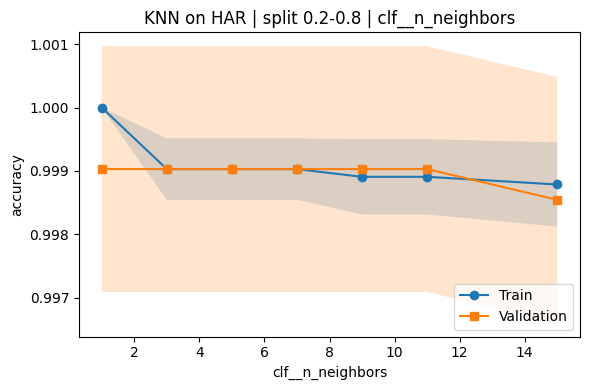

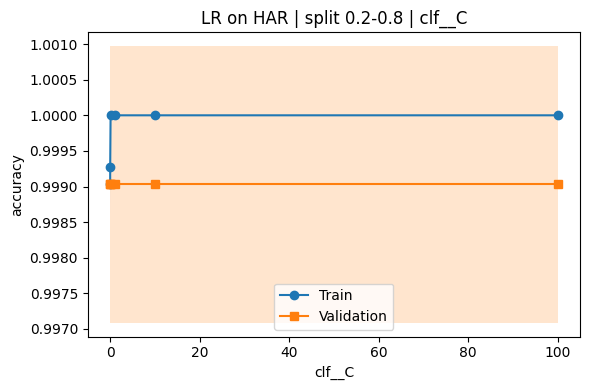

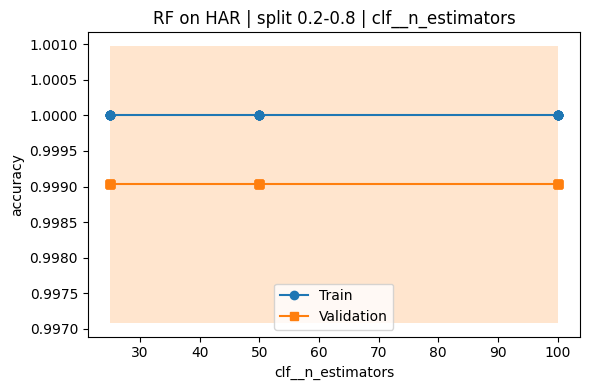

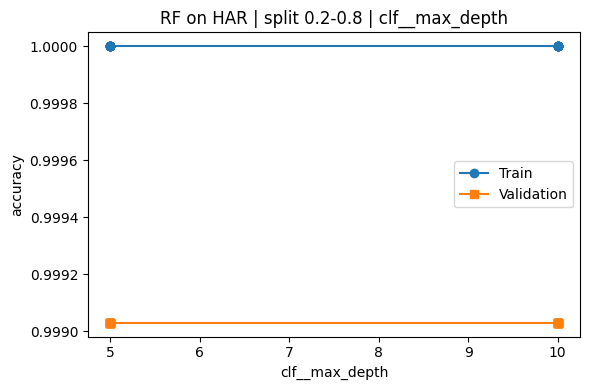

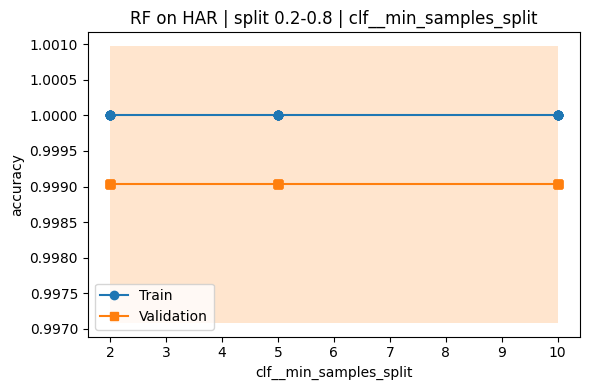

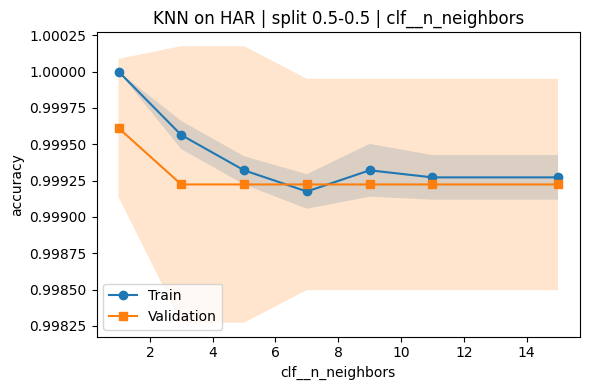

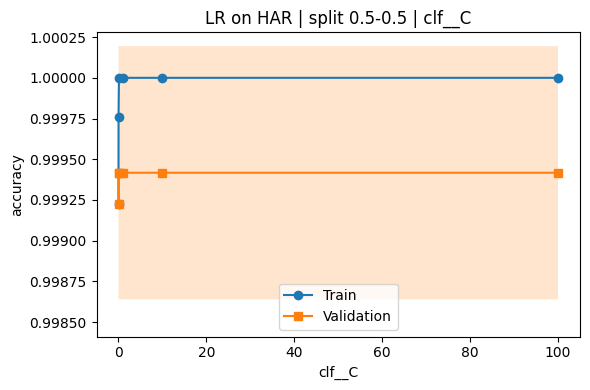

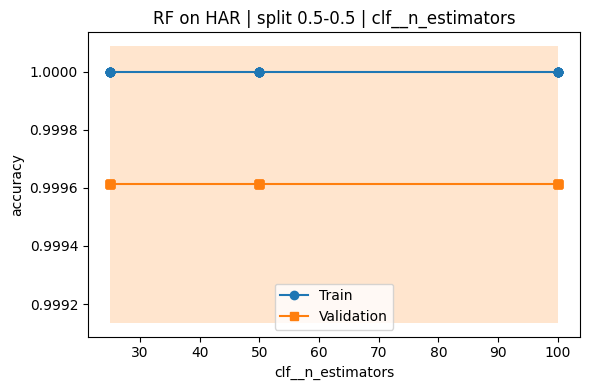

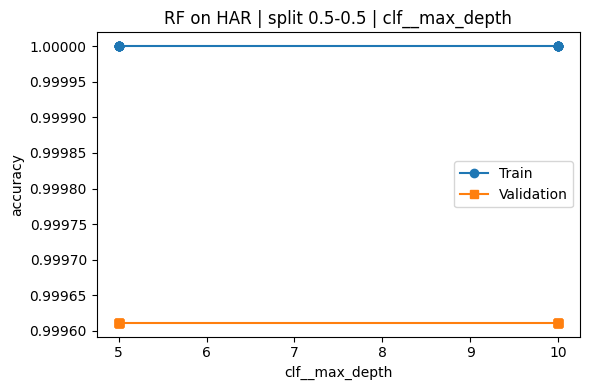

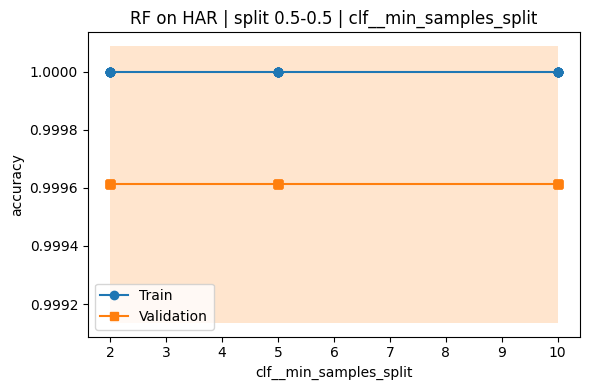

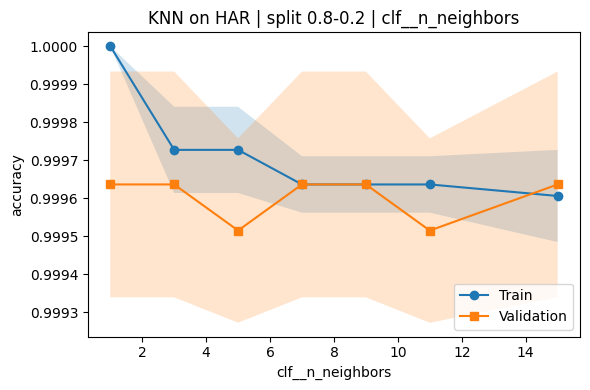

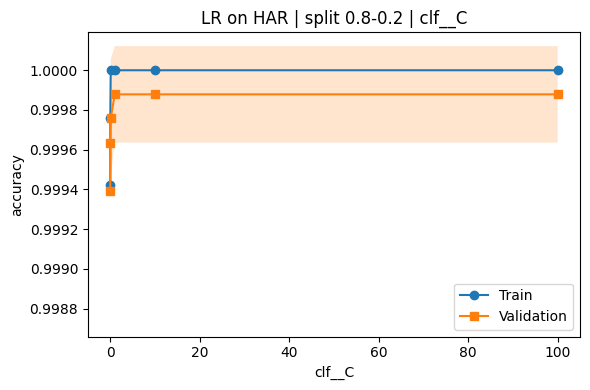

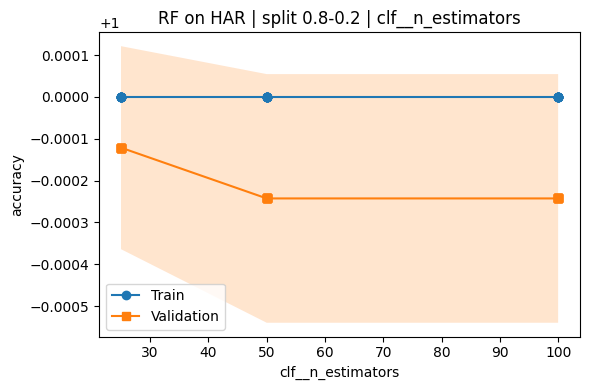

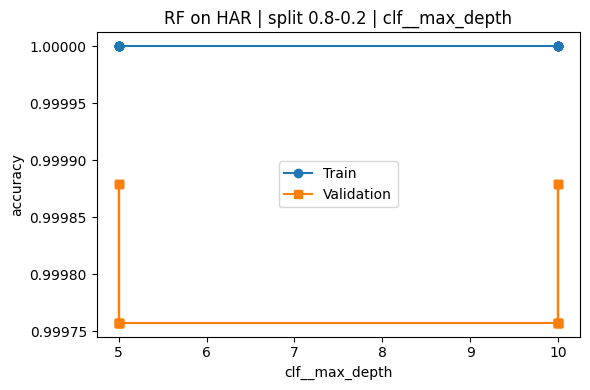

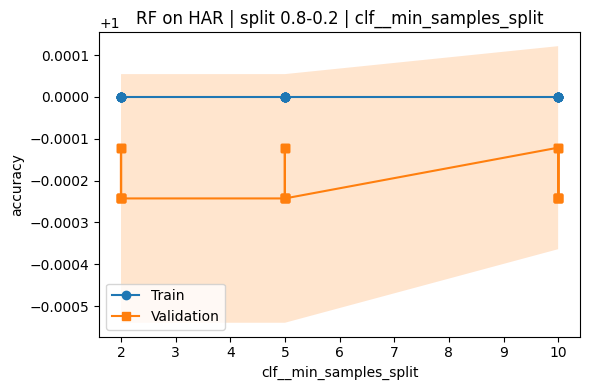

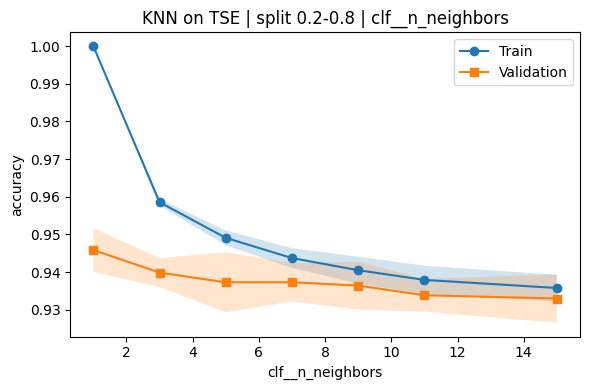

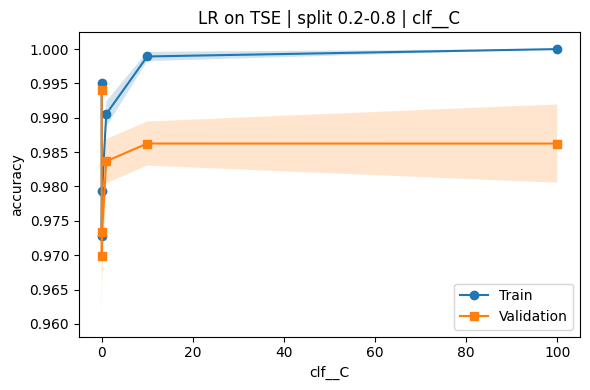

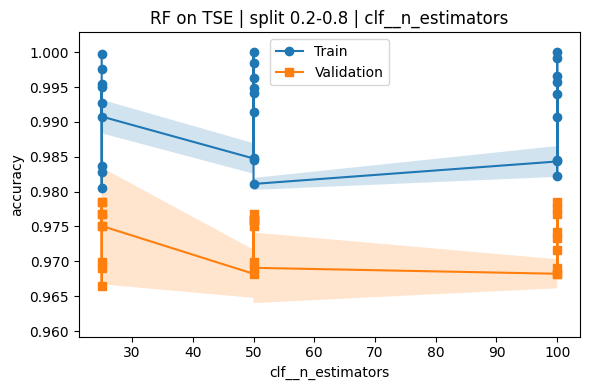

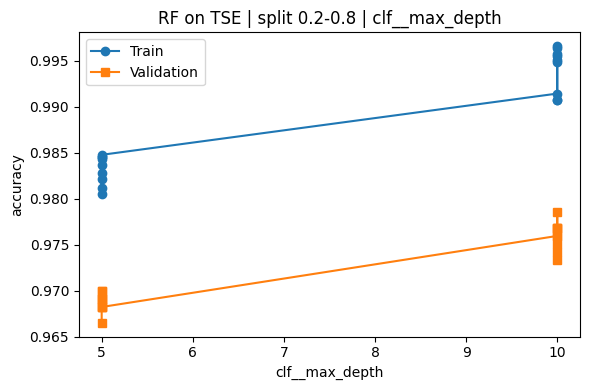

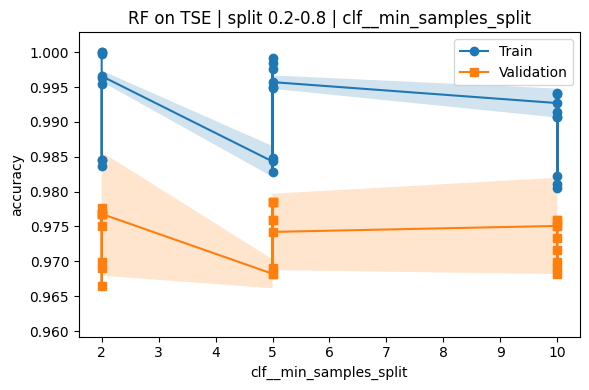

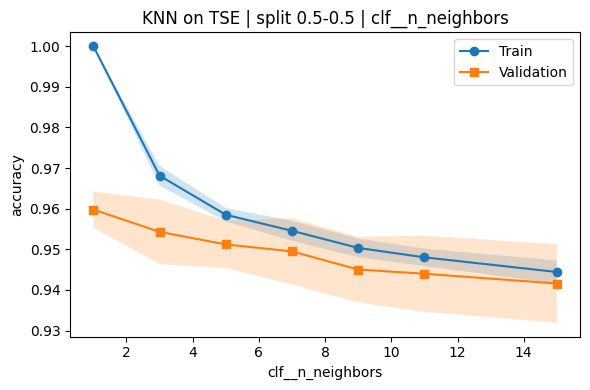

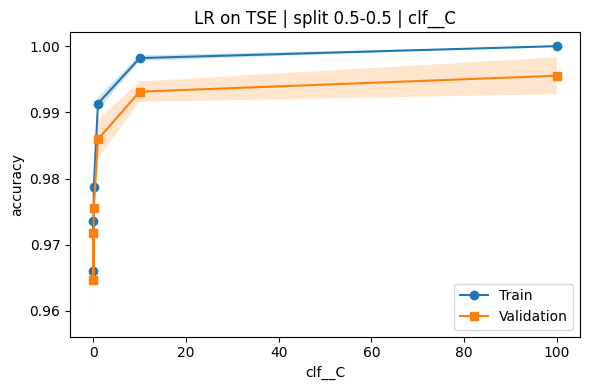

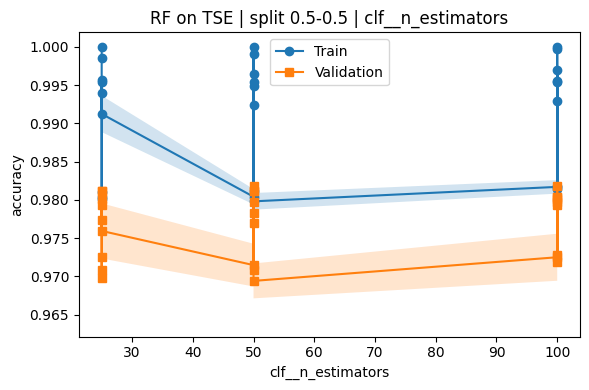

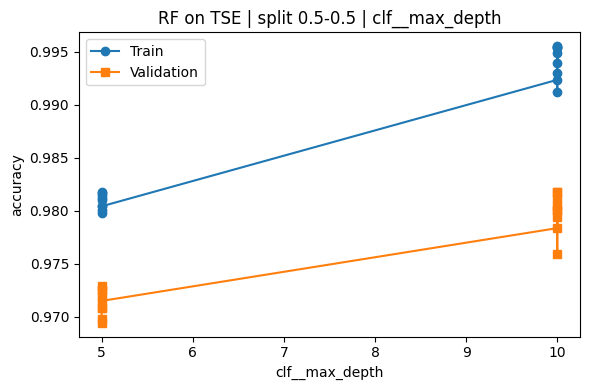

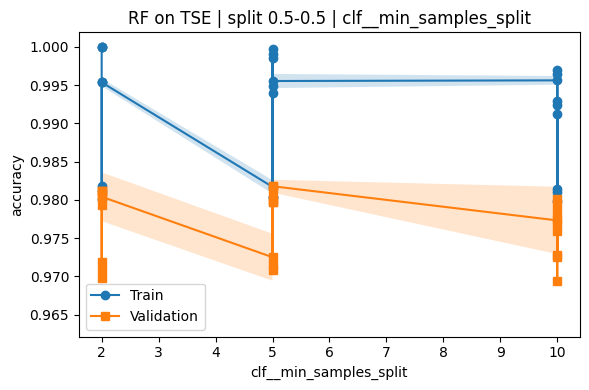

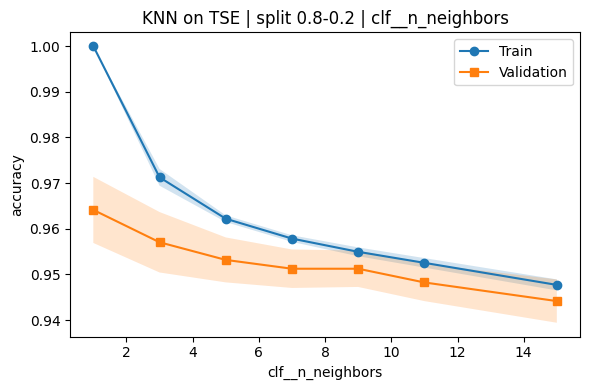

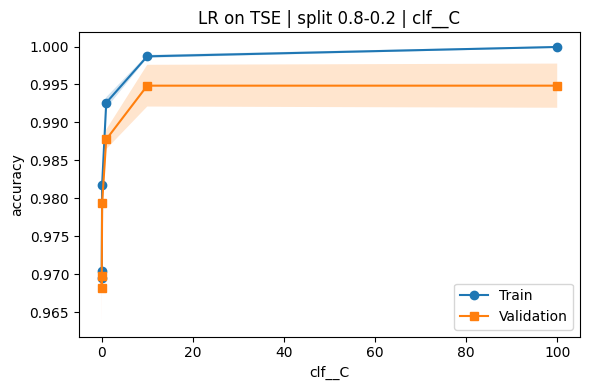

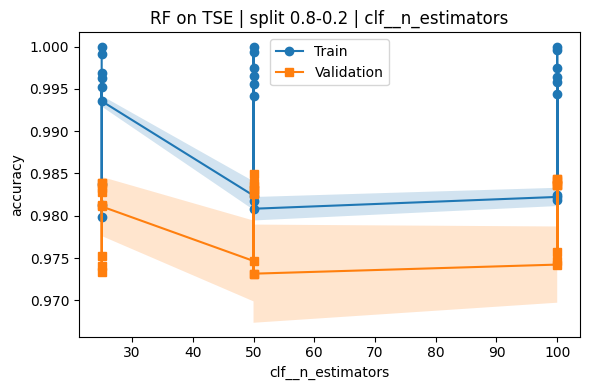

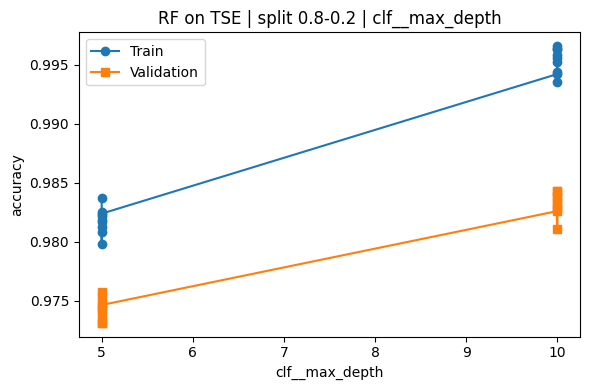

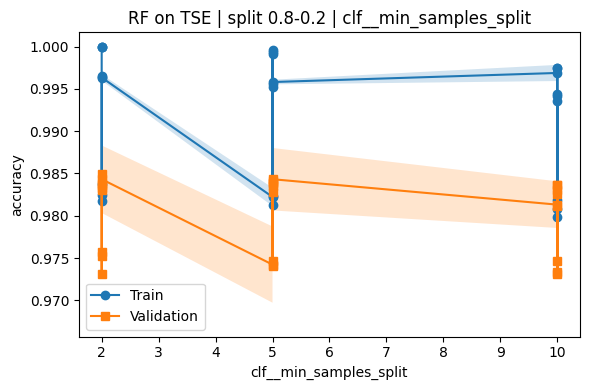

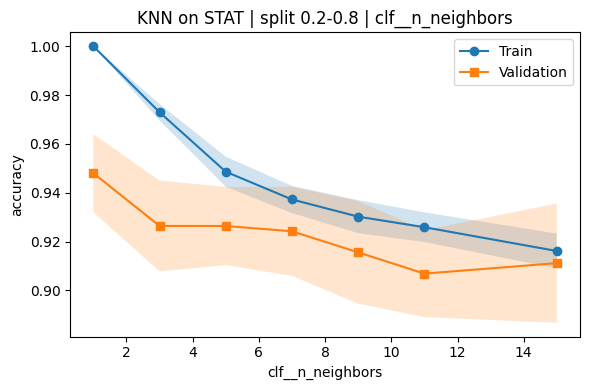

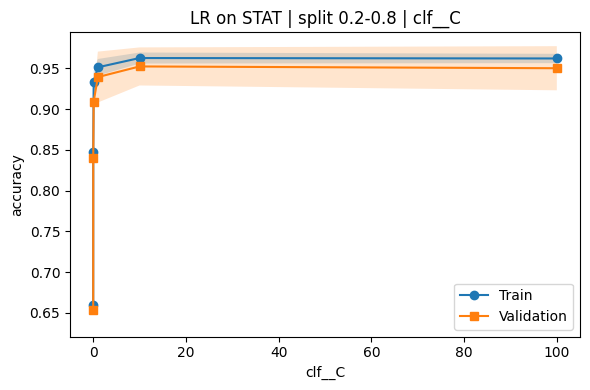

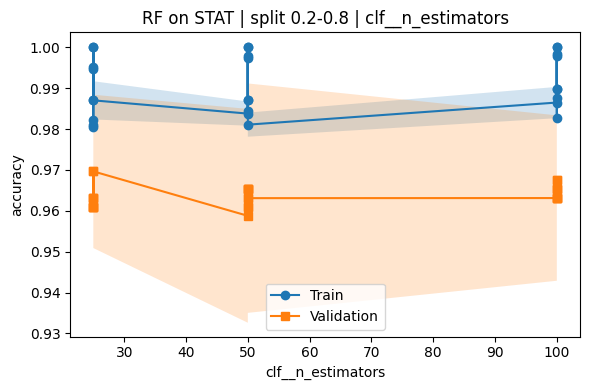

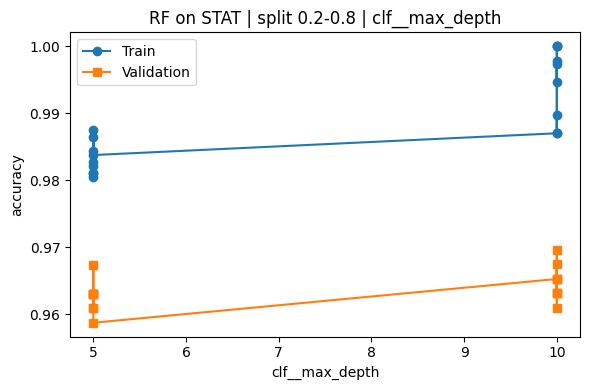

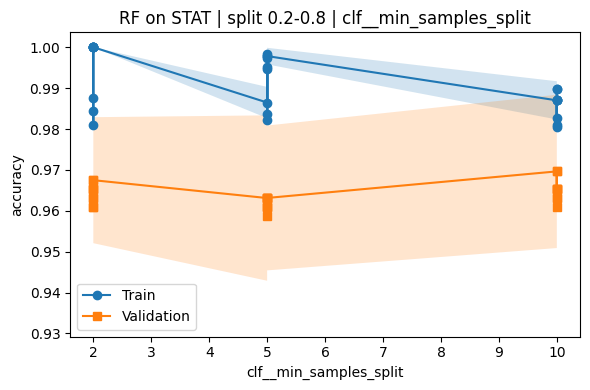

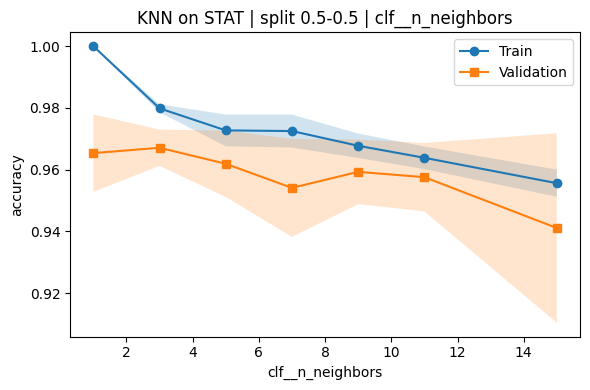

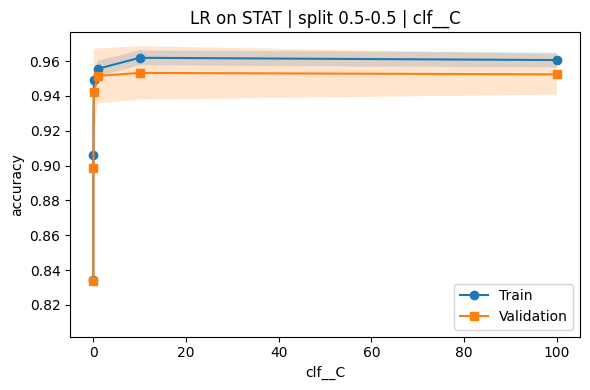

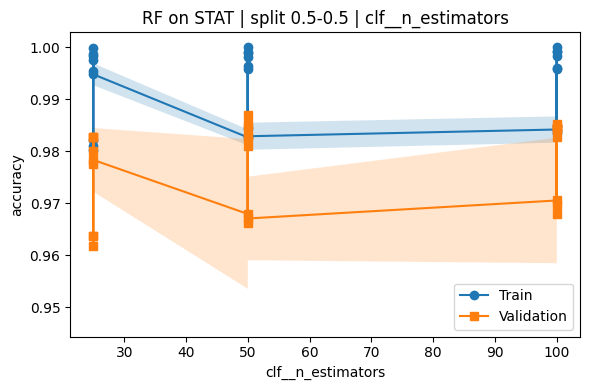

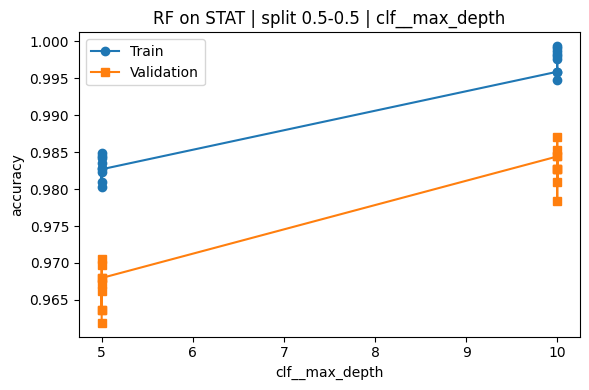

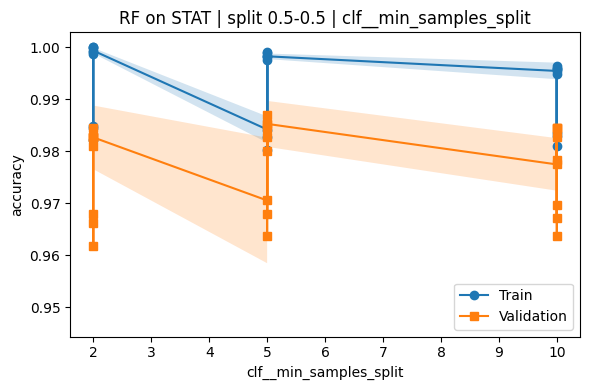

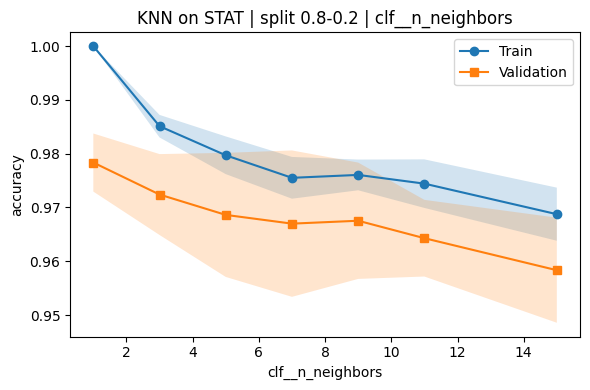

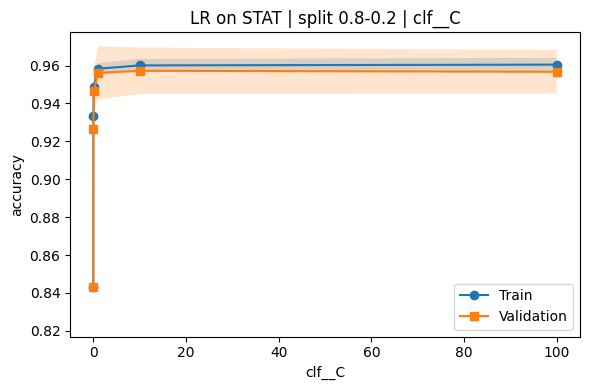

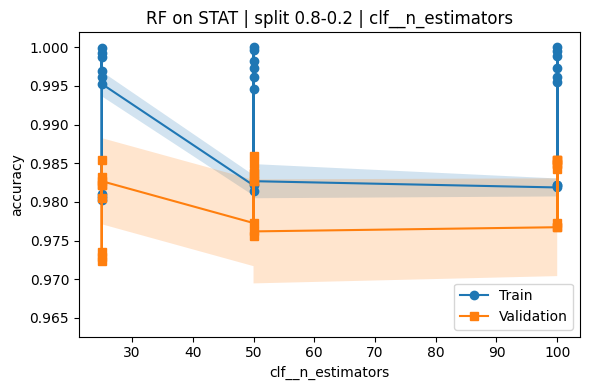

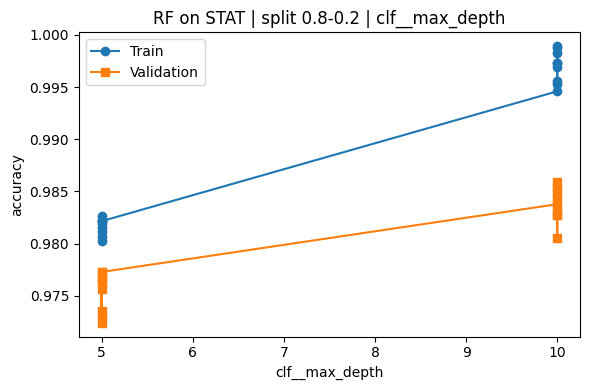

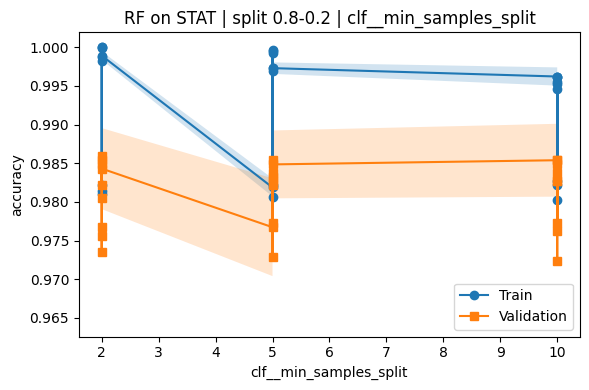

In [13]:
# ~~~~~~~~ STEP 6: VISUALIZATION ~~~~~~~~ 

# for storing all plots to results directory
CV_DIR = "cv_plots"
os.makedirs(CV_DIR, exist_ok=True)

def vis(grid_search, param_name, metric='accuracy', title=None, save=True):
    df = pd.DataFrame(grid_search.cv_results_)
    df = df.sort_values(f'param_{param_name}')

    train_mean = df['mean_train_score']
    train_std = df['std_train_score']
    val_mean = df['mean_test_score']
    val_std = df['std_test_score']

    param_values = df[f'param_{param_name}'].values

    plt.figure(figsize=(6, 4))

    # Always plot means
    plt.plot(param_values, train_mean, label='Train', marker='o')
    plt.plot(param_values, val_mean, label='Validation', marker='s')

    # Only fill if param is numeric
    if np.issubdtype(pd.Series(param_values).dropna().dtype, np.number):
        plt.fill_between(param_values,
                          train_mean - train_std,
                          train_mean + train_std,
                          alpha=0.2)
        plt.fill_between(param_values,
                          val_mean - val_std,
                          val_mean + val_std,
                          alpha=0.2)

    plt.xlabel(param_name)
    plt.ylabel(metric)
    plt.title(title if title else f'{metric.capitalize()} vs {param_name}')
    plt.legend()
    plt.tight_layout()
    
    # save plot to results
    if save:
        # Clean filename
        safe_title = title.lower().replace(" ", "_").replace("|", "")
        filename = f"{safe_title}.png"
        filepath = os.path.join(CV_DIR, filename)
        plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()


def vis_all(grid_searches, param_grids):
    for (dataset_name, clf_name, split), gs in grid_searches.items():
        if not gs:
            continue
        
        for param_name in param_grids[clf_name]:
            title = f"{clf_name.upper()} on {dataset_name} | split {split} | {param_name}"
            vis(gs, param_name, metric='accuracy', title=title)

vis_all(grid_searches, param_grids)